In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#導入環境
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.models import load_model
from keras.layers import * #引入層數
from keras.callbacks import TensorBoard


from sklearn import  preprocessing
from sklearn.preprocessing import *

In [48]:
#從雲端匯入資料
DATA_ROOT = '/content/drive/MyDrive/Colab Notebooks/ntut-ml-regression-2021'
print(os.listdir(DATA_ROOT))

['sampleSubmission.csv', 'train-v3.csv', 'test-v3.csv', 'valid-v3.csv', 'metadata.csv']


In [53]:
#匯入資料
data_train = pd.read_csv(f'{DATA_ROOT}/train-v3.csv')
data_valid = pd.read_csv(f'{DATA_ROOT}/valid-v3.csv')
data_test = pd.read_csv(f'{DATA_ROOT}/test-v3.csv')

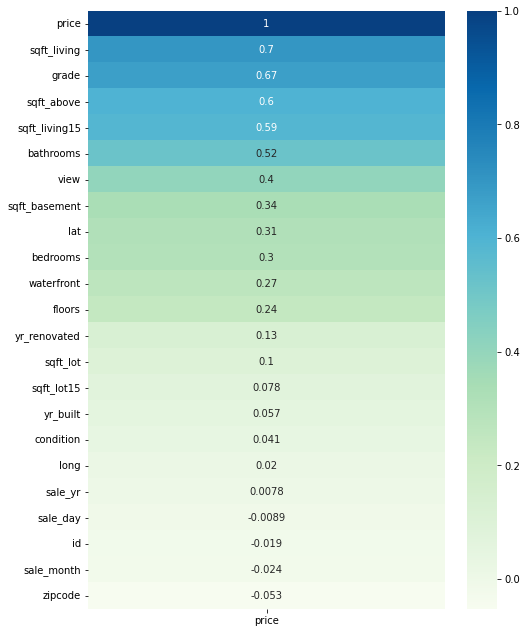

In [31]:
import seaborn as sns   # 引入Seaborn

train_corr = data_train.corr(method = "pearson")[['price']].sort_values(by="price", ascending=False)
plt.subplots(figsize=(8,11))
sns.heatmap(train_corr,annot=True, vmax=1, cmap='GnBu')
#print(train_corr)

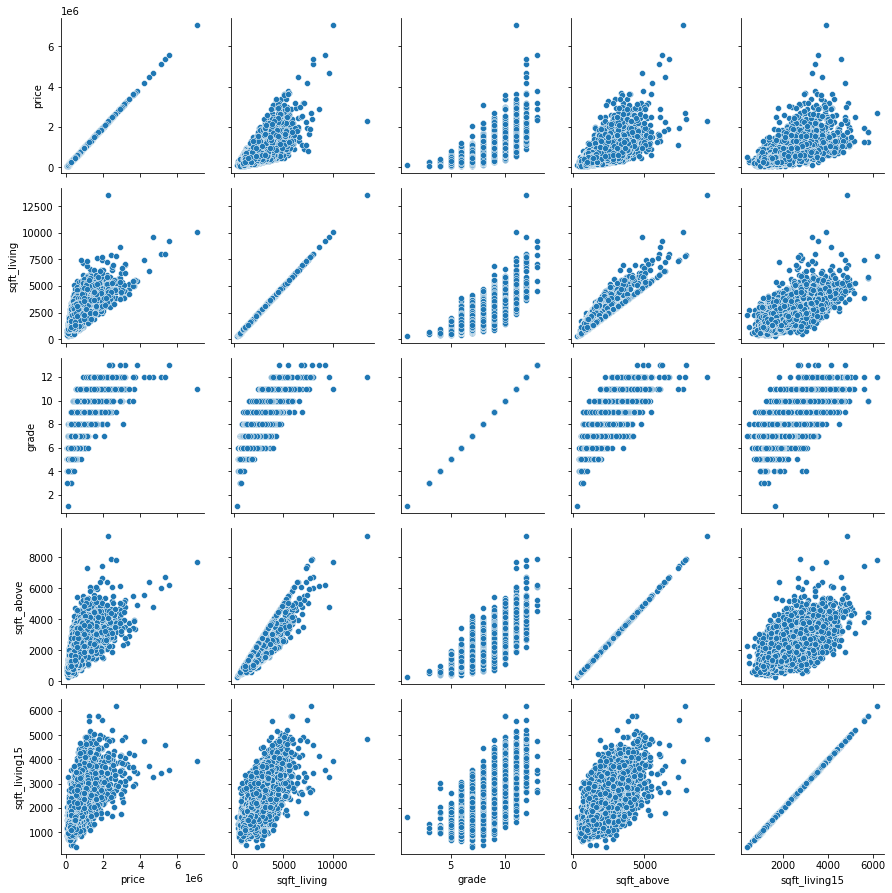

In [6]:
from pandas.plotting import scatter_matrix

attr = ['price','sqft_living',"grade",'sqft_above','sqft_living15']
hp= data_train[attr]
g=sns.PairGrid(hp)
g.map(sns.scatterplot)

In [63]:
def dataprocess(var):  
  #房屋面積跟沒有地下室面積關
  var['abo_liv'] = var['sqft_living'] - var['sqft_above']
  #是不是在地下室
  var['havebase']=0
  myindex = var[var['abo_liv'] == 0].index.tolist()
  for i in myindex:
    var.loc[i, 'havebase'] = 1
  #房間跟廁所的總和
  var['bed_sum_bat']= var['bathrooms'] + var['bedrooms']
  #房間跟廁所的差值
  var['bed_min_bat'] = var['bathrooms'] - var['bedrooms']
  #房間跟廁所的數量在面積上的關係
  var['BBR'] = (var['bathrooms'] + var['bedrooms']) / var['sqft_living']
  # 房屋面積跟沒有地下室面積關跟地方平方英尺關係
  var['abo_liv_div_lot'] = var['abo_liv'] * var['sqft_lot']
  #多少地多大客廳
  var[' howbigliving'] = var['sqft_living15'] / var['sqft_lot15']
  #豪華景觀高樓層
  var['bigview'] = var['view'] * var[ 'waterfront'] + var['floors']
  #房屋年齡
  var['age']=var['sale_yr']-var['yr_built']
  #出售前房屋整修年齡
  var['age_rnv']=0
  myindex = var[var['yr_renovated'] != 0].index.tolist()
  for i in myindex:
    var.loc[i, 'age_rnv'] = np.log1p(var.at[i, 'yr_renovated'] - var.at[i, 'yr_built'])
  myindex = var[var['yr_renovated'] > var['sale_yr']].index.tolist()
  for i in myindex:
    var.loc[i, 'age_rnv'] = 0
  
  change_data = pd.concat([var['abo_liv'],var['havebase'], var['bed_sum_bat'],var['bed_min_bat'],var['BBR'],
                var['abo_liv_div_lot'],var[' howbigliving'],var['bigview'],var['age'],var['age_rnv']],axis=1)
  return change_data

In [70]:
data_change=dataprocess(data_train)
data_change.head(20)

,abo_liv,havebase,bed_sum_bat,bed_min_bat,BBR,abo_liv_div_lot,howbigliving,bigview,age,age_rnv
0,0,1,6.00,-2.00,0.003158,0,0.195958,1,40,0.0
1,1050,0,7.00,-1.00,0.002071,16939650,0.225225,1,55,0.0
2,620,0,5.00,-1.00,0.002415,5580000,0.206722,1,45,0.0
3,0,1,4.00,-2.00,0.003478,0,0.167190,1,72,0.0
4,0,1,5.50,-0.50,0.002696,0,0.289218,2,28,0.0
5,0,1,4.00,-2.00,0.002581,0,0.174550,1,53,0.0
6,0,1,5.50,-0.50,0.003618,0,0.246879,2,29,0.0
7,0,1,3.00,-1.00,0.003797,0,0.172097,1,70,0.0
8,700,0,4.50,-1.50,0.002368,6815900,0.171511,1,46,0.0
9,1080,0,8.25,-1.75,0.001919,54437400,0.064293,2,43,0.0


In [23]:
#進行數據清洗(缺失值檢缺失值檢查、重複值檢查、數據類型轉換、剔除異常值)
def get_missing_values(df):
  tatal= df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([tatal,percent],axis=1 ,keys=['Total','Percent'])
  return(missing_data)
test_miss=get_missing_values(data_train)
test_miss.head


<bound method NDFrame.head of                Total  Percent
sqft_lot15         0      0.0
waterfront         0      0.0
price              0      0.0
sale_yr            0      0.0
sale_month         0      0.0
sale_day           0      0.0
bedrooms           0      0.0
bathrooms          0      0.0
sqft_living        0      0.0
sqft_lot           0      0.0
floors             0      0.0
view               0      0.0
sqft_living15      0      0.0
condition          0      0.0
grade              0      0.0
sqft_above         0      0.0
sqft_basement      0      0.0
yr_built           0      0.0
yr_renovated       0      0.0
zipcode            0      0.0
lat                0      0.0
long               0      0.0
id                 0      0.0>

In [21]:
X_train = data_train.drop(['price','id','zipcode','sale_yr','sale_day','sale_month'],axis=1).values  #先將price and id 刪除
Y_train = data_train['price'].values            #只保留price

X_valid = data_valid.drop(['price','id','zipcode','sale_yr','sale_day','sale_month'],axis=1).values  #刪除行 axis=0 刪除
Y_valid = data_valid['price'].values

X_test = data_test.drop(['id','zipcode','sale_yr','sale_day','sale_month'],axis=1).values

In [22]:
#資料標準化        新資料=(原值-均值)/標準差
scaler = StandardScaler().fit(X_train)
X_train = scale(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


In [13]:
#建模
model = Sequential()  #建立Sequential模型
model.add(Dense(100, input_dim = X_train.shape[1], kernel_initializer='normal',activation='relu'))  #激勵函數，處理非線性問題
model.add(Dense(150,  kernel_initializer='normal',activation='relu'))
model.add(Dense(200,  kernel_initializer='normal',activation='relu'))
model.add(Dense(160,  kernel_initializer='normal',activation='relu'))
model.add(Dense(100,  kernel_initializer='normal',activation='relu'))

model.add(Dense(1, kernel_initializer='normal',activation='linear'))

model.compile(loss='MAE', optimizer='adam') #預測值與真實值之間的差異，MAE=平均絕對值誤差
epochs = 100
batch_size = 20

In [ ]:
file_name = str(epochs)+'_'+str(batch_size)
TB = TensorBoard(log_dir='lods/'+file_name, histogram_freq=0)
history = model.fit(X_train,Y_train,batch_size=batch_size, 
                    epochs=epochs,validation_data=(X_valid, Y_valid),callbacks=[TB])

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_146 (Dense)           (None, 100)               1800      
                                                                 
 dense_147 (Dense)           (None, 160)               16160     
                                                                 
 dense_148 (Dense)           (None, 200)               32200     
                                                                 
 dense_149 (Dense)           (None, 140)               28140     
                                                                 
 dense_150 (Dense)           (None, 100)               14100     
                                                                 
 dense_151 (Dense)           (None, 1)                 101       
                                                                 
Total params: 92,501
Trainable params: 92,501
Non-tra

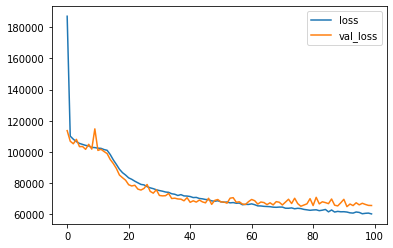

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()
model.summary()

In [ ]:
#儲存
Y_predict = model.predict(X_test)
with open("final.csv","w") as f :
  f.write('id,price\n')
  for i in range(len(Y_predict)):
    f.write(str(i+1) + ',' + str(float(Y_predict[i])) + "\n")